# CS156 Week 11 Assignment

2017-11-19

Also available at:

https://github.com/guydav/minerva/blob/master/notebooks/CS156/11.X%20Markov%20Models.ipynb

In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
import GPy
import glob
from functools import reduce
from IPython.display import display

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Markov Models
The code below trains a simple Markov model for given data. The transition probabilities are simply the observed transition counts normalized to valid probability simplexes on each row of the matrix. 

In (somewhat) conforming with `sklearn` API, the model implements `fit` and `score`, as well as helper methods with convenience interfaces. 

In [3]:
ALPHABET = ['A', 'o', 'e', 't', 'p', 'g', 'k']
TRAINING_FILE_PATTERN = 'data/markov/symbol/language-training-lang{lang}-*'
TEST_FILE_PATTERN = 'data/markov/symbol/language-test-*'


class MarkovModel:
    def __init__(self, alphabet=ALPHABET):
        self.map = {letter: index for (index, letter) in enumerate(ALPHABET)}
        self.transitions = np.zeros((len(ALPHABET), len(ALPHABET)))
        self.probabilities = np.ones_like(self.transitions)  # default initialization    
    
    def fit(self, sequence):
        for first, second in zip(sequence, sequence[1:]):
                self.transitions[self.map[first], self.map[second]] += 1
                
        self.probabilities = self.transitions / np.sum(self.transitions, axis=1)
    
    def fit_from_path(self, path):
        with open(path) as f:
            sequence = f.read()
            self.fit(sequence)

    def fit_from_glob(self, pattern):
        for path in glob.glob(pattern):
            self.fit_from_path(path)
    
    def score(self, sequence, log=False):
        log_prob = np.sum([np.log(self.probabilities[self.map[first], self.map[second]])
                       for first, second in zip(sequence, sequence[1:])])
        if not log:
            return np.exp(log_prob)

        return log_prob
    

## Genertive Markov Model classifier

The code below implements a simple generative Markov model classifier. For a new input sequence $v_{1:T}^*$, and a given class $c$, the model considers the posterior $P(c | v_{1:T}^*) \propto P(v_{1:T}^* | c) P(c)$, the product of the data's likelihood according to the class multiplied by the prior for that class - Bayes's rule. To normalize, we must divide by the sum of posterior probabilities over all classes: 

$$ P(c | v_{1:T}^*) = \frac{P(v_{1:T}^* | c) P(c)}{\sum_{c' \in C} P(v_{1:T}^* | c') P(c')} $$

To classify, the model selects the argmax class over all class probabilities. In conforming with the `sklearn` API, the model implements `predict_proba`, `predict`, and `score`.

In [4]:
LANGUAGES = ('A', 'B', 'C')


class GenerativeMarkovModelClassifier:
    def __init__(self, prior=None, langauges=LANGUAGES):
        self.n = len(langauges)
        self.classes = langauges
        self.models = [MarkovModel() for i in range(self.n)]
        
        if not prior:
            self.prior = np.ones((self.n,)) / self.n

        elif not type(prior) == dict:
            if not len(prior) == self.n:
                raise ValueError('Prior and languages should have the same length')
                
            if not 1.0 == sum(prior):
                raise ValueError('Prior should sum up to 1')
            
            if any(prior < 0) or any (prior > 1):
                raise ValueError('Prior should be a valid probability simplex')
                
            self.prior = prior
    
    def fit_from_pattern(self, training_file_pattern=TRAINING_FILE_PATTERN):
        for (lang, model) in zip(self.classes, self.models):
            model.fit_from_glob(training_file_pattern.format(lang=lang))

    def predict_proba(self, sequence):
        probs = np.array([model.score(sequence) for model in self.models]) * self.prior
        return probs / np.sum(probs)
            
    def predict(self, sequence):
        probs = self.predict_proba(sequence)
        return self.classes[np.argmax(probs)]
    
    def score(self, sequence):
        return np.max(self.predict_proba(sequence))
    
    def predict_from_pattern(self, test_file_pattern=TEST_FILE_PATTERN, probs=False):
        predictions = []
        
        for path in glob.glob(test_file_pattern):
            with open(path) as f:
                sequence = f.read()
                if probs:
                    predictions.append(self.predict_proba(sequence))
                else:
                    predictions.append(self.predict(sequence))
            
        return predictions
    

In [5]:
gmmc = GenerativeMarkovModelClassifier()
gmmc.fit_from_pattern()
gmmc.predict_from_pattern()

 /Users/guydavidson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning:divide by zero encountered in log


['C', 'C', 'A', 'B', 'A', 'A', 'B', 'A', 'C', 'A']

## HMM 

Given that there are three speakers in the room, we should set $H = 3$, making $A$ a $3 \times 3$ matrix, and given the same seven phonemes from the previous exercise, we should set $V = 7$, making $B$ a $3 \times 7$ matrix.

A reasonable assumption is to set $\vec{a} = [\frac{1}{3}, \frac{1}{3}, \frac{1}{3}]^T$, a uniform distribution over the initial probabilities of each speaker starting. 

Note: 

$A_{ij} = P(h_{t + 1} = j | h_t = i)$, the row-major matrix notation.

$B_{ij} = P(v_t = j | h_t = i)$, again, row-major, unlike Barber's notation

In [6]:
ALPHABET = ['A', 'o', 'e', 't', 'p', 'g', 'k']

data = open('data/hmm/speaker').read()
transitions = list(zip(data, data[1:]))
mapping = {letter: index for (index, letter) in enumerate(ALPHABET)}
mapped_data = [mapping[v] for v in data]
mapped_transitions = [(mapping[a], mapping[b]) for (a, b) in transitions]

### Filtering

To implement filtering, we compute the forwards pass of $\alpha$ messages, using the following recursion:

$$ \alpha(h_t) = p(h_t | v_{1:t}) = p(v_t | h_t) \sum_{h_{t-1}} p(h_t | h_{t-1}) \alpha(h_{t-1})  $$

Which if we consider the factor graph, is just the product of messages from $v_t$ and $h_{t-1}$. The base case includes the messages from $v_1$ and the prior over $a$: $\alpha(h_1) = p(h_1)p(v_1 | h_1)$

In [33]:
def alpha(a, A, B, mapped_data):
    h_1 = np.multiply(a, B[:,mapped_data[0]])
    messages = [h_1 / h_1.sum()]
    
    for v_t in mapped_data[1:]:
        # p(v_t | h_t)
        corrector = B[:,v_t]  
        # \sum_{h_{t-1}} p(h_t | h_{t-1}) \alpha(h_{t-1})
        predictor = np.sum([messages[-1][h_prev] * A[h_prev,:] for h_prev in range(a.shape[0])])
        unnormalized = np.multiply(corrector, predictor)
        messages.append(unnormalized / unnormalized.sum())
    
    return messages


def log_alpha(a, A, B, mapped_data):
    h_1 = np.log(a) + np.log(B[:,mapped_data[0]])
    messages = [h_1]
    
    for v_t in mapped_data[1:]:
        # p(v_t | h_t)
        corrector = np.log(B[:,v_t])
        # \sum_{h_{t-1}} p(h_t | h_{t-1}) \alpha(h_{t-1})
        predictor = np.log(np.sum(np.exp([messages[-1][h_prev] + np.log(A[h_prev,:]) 
                                          for h_prev in range(a.shape[0])])))
        unnormalized = corrector + predictor
        unnormalized -= unnormalized.max()
        messages.append(unnormalized)
    
    return messages
                                         
unnorm_log = np.exp(np.array(log_alpha(a, A, B, mapped_data))) 
unnorm_log = unnorm_log / unnorm_log.sum(axis=1)[:, np.newaxis]
np.sum(unnorm_log - np.array(alpha(a, A, B, mapped_data)))

-6.7723604502134549e-15

### Parallel Smoothing
To implement parallel smoothing, we must also compute the backwards pass: 

$$ P(h_t, v_{1:T}) = P(h_t, v_{1:t}, v_{t+1:T}) = P(h_t | v_{1:t}) P(v_{t+1:T} | h_t) = \alpha(h_t) \beta(h_t) $$

Thus, defining $\beta(h_t) \equiv p(v_{t+1:T} | h_t)$, we compute it recursively as:

$$ \beta(h_{t-1}) = \sum_{h_t} p(v_t | h_t) P(h_t | h_{t-1}) \beta(h_t) $$

With the base case of $\beta(h_T) = 1$. Again, if we think of the factor graph, the message $\beta(h_t)$ is simply the mesage from $h_{t+1}$ to $h_t$

In [40]:
def beta(a, A, B, mapped_data):
    messages = [np.ones_like(a) / a.shape[0]]
    
    for v_t in reversed(mapped_data[:-1]):
        b = np.multiply(np.matmul(B.T, A).sum(axis=0), messages[-1])
        messages.append(b / b.sum())
    
    return messages


def log_beta(a, A, B, mapped_data):
    messages = [np.log(np.ones_like(a) / a.shape[0])]
    
    for v_t in reversed(mapped_data[:-1]):
        b = np.log(np.matmul(B.T, A).sum(axis=0)) + messages[-1]
        b -= b.max()
        messages.append(b)
    
    return messages


unnorm_log = np.exp(np.array(log_beta(a, A, B, mapped_data))) 
unnorm_log = unnorm_log / unnorm_log.sum(axis=1)[:, np.newaxis]
np.sum(unnorm_log - np.array(beta(a, A, B, mapped_data)))

1.4228083337869884e-15

### Smoothed Posterior
The smoothed posterior is hence given by:

$$ P(h_t | v_{1:T}) \equiv \gamma(h_t) = \frac{\alpha(h_t) \beta(h_t)}{\sum_{h_t} \alpha(h_t) \beta(h_t)} $$

Which if we think in terms of the factor graph represents the marginal over $h_t$, the locally normalized product of all incoming messages.

In [42]:
def gamma(alpha_messages, beta_messages):
    gamma_messages = np.multiply(alpha_messages, beta_messages)
    return gamma_messages / gamma_messages.sum(axis=1)[:, np.newaxis]


def log_gamma(log_alpha_messages, log_beta_messages):
    gamma_messages = np.array(log_alpha_messages) + np.array(log_beta_messages)
    return gamma_messages - gamma_messages.max(axis=1)[:, np.newaxis]


unnorm_log = np.exp(np.array(log_gamma(log_alpha(a, A, B, mapped_data), log_beta(a, A, B, mapped_data)))) 
unnorm_log = unnorm_log / unnorm_log.sum(axis=1)[:, np.newaxis]
np.sum(unnorm_log - np.array(gamma(alpha(a, A, B, mapped_data), beta(a, A, B, mapped_data))))

-7.7861129416909518e-16

### Pairwise Marginal

Following the explicit definition, we use the messages to compute the pairwise marginal:

$$ P(h_t, h_{t+1} | v_{1:T}) \propto \alpha(h_t) P(h_{t+1} | h_t) p(v_{t+1} | h_{t+1}) \beta(h_{t+1}) $$

The result should be an $H \times H$ matrix, in which $M_{ij} = P(h_t = i, h_{t+1} = j | v_{1:T})$

This is easier to think of in terms of a junction tree - it represents the posterior over the clique $\{h_t, h_{t+1}\}$

In [60]:
def pairwise_marginals(alpha_messages, beta_messages, mapped_data):
    marginals = []
    
    for t in range(len(mapped_data) - 1):
        a_t = alpha_messages[t]
        b_t_1 = beta_messages[t + 1]
        v_t_1 = mapped_data[t + 1]
        p_v_t_1 = B[:,v_t_1]
        
        left_product = np.multiply(a_t, A.T).T
        right_product = np.multiply(p_v_t_1, b_t_1)
        prod = np.multiply(left_product, right_product)
        marginals.append(prod / np.sum(prod))
        
    return marginals


def pairwise_marginals_by_loop(alpha_messages, beta_messages, mapped_data):
    marginals = []
    
    h_size = len(alpha_messages[0])
    
    for t in range(len(mapped_data) - 1):
        marginal = np.zeros((h_size, h_size))
        
        for h_t in range(h_size):
            for h_t_1 in range(h_size):
                a_t = alpha_messages[t][h_t]
                b_t_1 = beta_messages[t + 1][h_t_1]
                
                v_t_1 = mapped_data[t + 1]
                p_v_t_1 = B[:,v_t_1][h_t_1]
                
                p_h_t_1_h_t = A[h_t, h_t_1]
                
                marginal[h_t, h_t_1] = a_t * b_t_1 * p_v_t_1 * p_h_t_1_h_t
            
        marginals.append(marginal / np.sum(marginal))
        
    return marginals

alphas = alpha(a, A, B, mapped_data)
betas = beta(a, A, B, mapped_data)
pmbl = np.array(pairwise_marginals_by_loop(alphas, betas, mapped_data[:5]))
pm = np.array(pairwise_marginals(alphas, betas, mapped_data[:5]))
np.sum(pmbl - pm)

-1.0408340855860843e-16

### EM Implementation
Using the functions defined above, we can now go into doing what we actually came here to do - implement the EM algorithm. The E-step is trivial:


In [49]:
def E_step(a, A, B, mapped_data):
    alpha_messages = alpha(a, A, B, mapped_data)
    beta_messages = beta(a, A, B, mapped_data)
    
    return gamma(alpha_messages, beta_messages), \
            pairwise_marginals(alpha_messages, beta_messages, mapped_data)

The M-step requires implementing the formulae provided by Barber:

$$ a_i^{new} \equiv P^{new}(h_1 = i) = \frac{1}{N} \sum_{n=1}^{N} p^{old}(h_1 = i | v^n)  $$

$$ A_{ij}^{new} \equiv P^{new}(h_{t+1} = j | h_t = i) \propto \sum_{n=1}^{N} \sum_{t=1}^{T_n -1} p^{old}(h_t = i, h_{t+1} = j | v^n) = \frac{\sum_{n=1}^{N} \sum_{t=1}^{T_n -1} p^{old}(h_t = i, h_{t+1} = j | v^n)}{\sum_j \sum_{n=1}^{N} \sum_{t=1}^{T_n -1} p^{old}(h_t = i, h_{t+1} = j | v^n)} $$


$$ B_{ij}^{new} \equiv P^{new}(v_t = j | h_t = i) \propto \sum_{n=1}^{N} \sum_{t=1}^{T_n -1} \mathbb{I}[v_t^n = j] p^{old}(h_t = i | v^n) $$

Note that in this case, we currently only have a single data point, so $n = 1$, and the summation over $n$ doesn't exist. Also note that all the $P^{old}$ are, infact, the quantities we computed in the E-step:

In [50]:
def M_step(node_posteriors, pair_marginals, mapped_data_matrix):
    a = node_posteriors[0]
    
    A = np.sum(pair_marginals, axis=0)
    A = A / A.sum(axis=1)[:, np.newaxis]
    
    node_posterior_matrix = np.array(node_posteriors).T
    B = np.matmul(node_posterior_matrix, mapped_data_matrix)
    B = B / B.sum(axis=1)[:, np.newaxis]
    
    return a, A, B

array([[ 0.42587319,  0.33309507,  0.24103174],
       [ 0.29050491,  0.50999757,  0.19949752],
       [ 0.16246437,  0.08572191,  0.75181372]])

[ 0.02202782  0.44824989  0.52972229] [[  1.00000000e+00   1.44597788e-12   2.02450124e-12]
 [  9.99999931e-01   6.83283682e-08   4.16651023e-10]
 [  9.99999943e-01   5.08451354e-08   5.73076958e-09]] [[  1.76172292e-001   1.88184039e-001   1.40159100e-001   1.68164460e-001
    1.67163481e-001   1.21118450e-001   3.90381783e-002]
 [  8.27078915e-058   1.99510409e-007   9.99999800e-001   0.00000000e+000
    1.96610194e-099   4.04046206e-015   0.00000000e+000]
 [  4.36416137e-072   2.68250712e-009   9.99999997e-001   0.00000000e+000
    2.23116222e-124   3.26344706e-019   0.00000000e+000]]


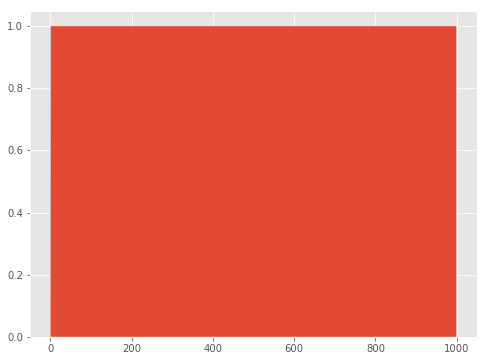

In [73]:
H = 3
V = 7
# A = np.array([[0.5, 0.25, 0.25], [0.25, 0.5, 0.25], [0.25, 0.25, 0.5]])
# A = np.ones((H, H)) + np.random.normal(0, 0.1, (H, H))
# A = A / A.sum(axis=1)[:, np.newaxis]
A = np.vstack([np.random.dirichlet(np.array([8, 2, 2])), 
           np.random.dirichlet(np.array([2, 8, 2])),
           np.random.dirichlet(np.array([2, 2, 8]))]) 

B = np.ones((H, V)) + np.random.normal(0, 0.1, (H, V))
B = B / B.sum(axis=1)[:, np.newaxis]
# B = np.random.dirichlet(np.ones((V,)), 3)
a = np.ones((H,)) / H  

def EM(a, A, B, mapped_data):
    mapped_data_matrix = np.zeros((len(mapped_data), V))
    for t, v_t in enumerate(mapped_data):
        mapped_data_matrix[t, v_t] = 1
        
    for i in range(3):
        node_posteriors, pair_marginals = E_step(a, A, B, mapped_data)
        a, A, B = M_step(node_posteriors, pair_marginals, mapped_data_matrix)
    
    return a, A, B
   
new_a, new_A, new_B = EM(a, A, B, mapped_data)
print(new_a, new_A, new_B)

plt.figure(figsize=(8, 6))
x = range(len(mapped_data))
posteriors, _ = E_step(new_a, new_A, new_B, mapped_data)
first, second, third = zip(*posteriors)
plt.stackplot(x, first, second, third)


## HMM using `hmmlearn`

See https://github.com/hmmlearn/hmmlearn

In [74]:
import hmmlearn
import hmmlearn.hmm


# consider playing with transmat_prior
transition_prior = np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]]) * 3
hmm = hmmlearn.hmm.MultinomialHMM(3, transmat_prior=transition_prior)
X = np.array(mapped_data).reshape((len(mapped_data), 1))
hmm.fit(X)

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=3,
        n_iter=10, params='ste',
        random_state=<mtrand.RandomState object at 0x10d0c75e8>,
        startprob_prior=1.0, tol=0.01,
        transmat_prior=array([[6, 3, 3],
       [3, 6, 3],
       [3, 3, 6]]),
        verbose=False)

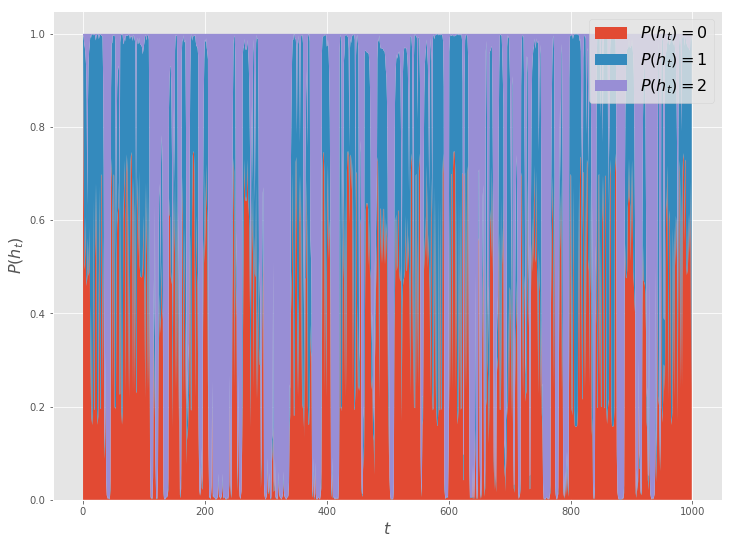

In [75]:
plt.figure(figsize=(12, 9))
x = range(len(mapped_data))
posteriors = hmm.predict_proba(X)
first, second, third = zip(*posteriors)
plt.stackplot(x, first, second, third, labels=['$P(h_t) = {i}$'.format(i=i) for i in range(3)])
plt.legend(loc='best', fontsize=16)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$P(h_t)$', fontsize=16)


I guess my implementation does indeed have a bug. Oh well.